In [1]:
from openparticle.hamiltonians import *
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix
import numpy as np
from openparticle.dlcq import *
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('text', usetex=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carterm.gustin/anaconda3/envs/openparticle/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [6]:
def plot_m2_vs_pp(Pplus_val, Lambda, g = 1):

    ham = yukawa_Hamiltonian(Lambda, g = g)
    evals = []
    pplus_arr = [i for i in range(0, Pplus_val + 1)]


    for pp in pplus_arr:
        pp_tmp_basis = Pplus_states_partition(pp)
        tmp_mat = generate_matrix(ham, pp_tmp_basis)
        
        evals.append(min(np.linalg.eigvalsh(tmp_mat)) * pp)

    # return evals, pplus_arr
    plt.figure(figsize=(3,3), dpi = 200)
    plt.scatter(pplus_arr[1:], np.array(evals)[1:], marker='.')
    # plt.yscale('symlog')
    plt.xlabel(f'$\Lambda$')
    plt.ylabel(f'$M^2$')
    plt.tight_layout()
    # plt.savefig('yukawa_spectrum.jpg')
    plt.show()

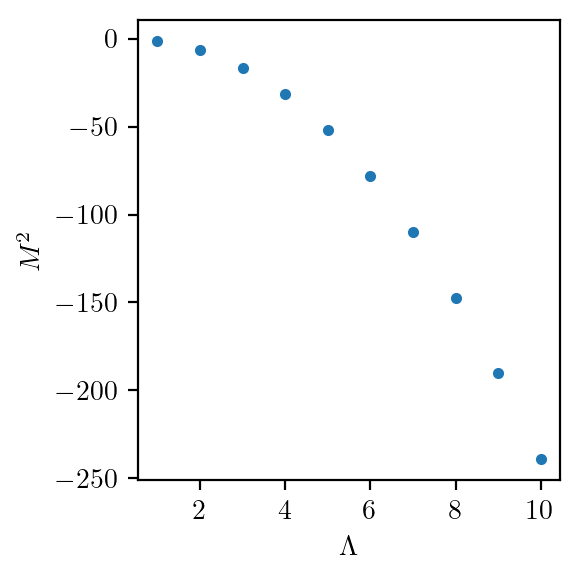

In [13]:
cut = 10
plot_m2_vs_pp(Pplus_val=cut, Lambda=cut, g = 1)

### Partition $H$ into blocks of definite $P^+$

Text(0.5, 1.0, '$\\Lambda = 2$')

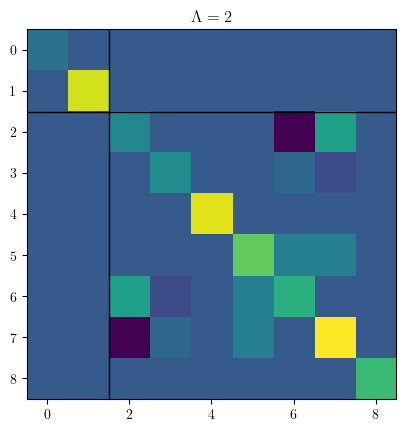

In [85]:
pp = 2
basis = [Pplus_states_partition(i)[j] for i in range(1, pp + 1) for j in range(len(Pplus_states_partition(i)))]
plt.imshow(
    np.real(
        generate_matrix(yukawa_Hamiltonian(pp), basis)
    )
)
n_states_i = 0
for i in range(1, pp):
    n_states_i += len(Pplus_states_partition(i))
    plt.axvline(x=n_states_i - 0.5, color='black', linewidth=1)
    plt.axhline(y=n_states_i - 0.5, color='black', linewidth=1)

plt.title(f'$\Lambda = {pp}$')

### Verify blocks can be diagonalized independently:

In [107]:
pp = 2
basis = [Pplus_states_partition(i)[j] for i in range(1, pp + 1) for j in range(len(Pplus_states_partition(i)))]
vals = np.linalg.eigvalsh(
    np.real(
        generate_matrix(yukawa_Hamiltonian(pp), basis)
    )
)
vals

array([-0.49956136,  0.46666667,  0.99314615,  1.43092248,  2.        ,
        3.26666667,  3.27396111,  3.37142857,  4.50153162])

In [95]:
np.linalg.eigvalsh(
    np.real(
        generate_matrix(yukawa_Hamiltonian(2), Pplus_states_partition(2))
    )
)

array([-0.49956136,  0.99314615,  1.43092248,  2.        ,  3.27396111,
        3.37142857,  4.50153162])

In [110]:
np.linalg.eigvalsh(
    np.real(
        generate_matrix(yukawa_Hamiltonian(2), Pplus_states_partition(1))
    )
)

array([0.46666667, 3.26666667])